In [11]:
import os
import cv2
import numpy as np
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


In [37]:
root_path = "frames/" 
actions = ["running", "handwaving", "boxing", "walking"]  

In [38]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Parámetros de Optical Flow
farneback_params = dict(
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
)

# Función para calcular histograma de ángulos con pesos de magnitud
def compute_flow_histogram(prev, next, bins=8):
    flow = cv2.calcOpticalFlowFarneback(prev, next, None, **farneback_params)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hist, _ = np.histogram(ang, bins=bins, range=(0, 2*np.pi), weights=mag)
    hist = hist / (np.sum(hist) + 1e-6)
    return hist

# Acumuladores globales
data = []
labels = []


# Número máximo de personas a procesar por acción
limit = 10  # Cambia este valor para procesar más o menos personas

# Recorrer todas las acciones y sus carpetas de personas
for action in actions:
    action_path = os.path.join(root_path, action)
    if not os.path.exists(action_path):
        continue
    
    count = 0  # Contador de personas procesadas
    for person_folder in sorted(os.listdir(action_path)):
        
        if count >= limit:  # Si alcanzamos el límite, rompemos el bucle
            break

        person_path = os.path.join(action_path, person_folder)
        if not os.path.isdir(person_path):
            continue

        frame_files = sorted([f for f in os.listdir(person_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        features = []
        for i in range(len(frame_files) - 1):
            frame1 = cv2.imread(os.path.join(person_path, frame_files[i]), cv2.IMREAD_GRAYSCALE)
            frame2 = cv2.imread(os.path.join(person_path, frame_files[i+1]), cv2.IMREAD_GRAYSCALE)
            if frame1 is None or frame2 is None:
                continue
            hist = compute_flow_histogram(frame1, frame2)
            features.append(hist)

        if features:
            aggregated = np.mean(features, axis=0)
            data.append(aggregated)
            labels.append(action)

        count += 1  # Incrementamos el contador

    print(f"Procesados {count} personas para la acción '{action}'")

Procesados 10 personas para la acción 'running'
Procesados 10 personas para la acción 'handwaving'
Procesados 10 personas para la acción 'boxing'
Procesados 10 personas para la acción 'walking'


In [39]:
# Convertir los datos a numpy arrays
X = np.array(data)
y = np.array(labels)

# Dividir los datos en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un clasificador KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
predictions = knn.predict(X_test)

# Evaluación: precisión
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"Precisión del clasificador KNN: {accuracy * 100:.2f}%")


Precisión del clasificador KNN: 75.00%


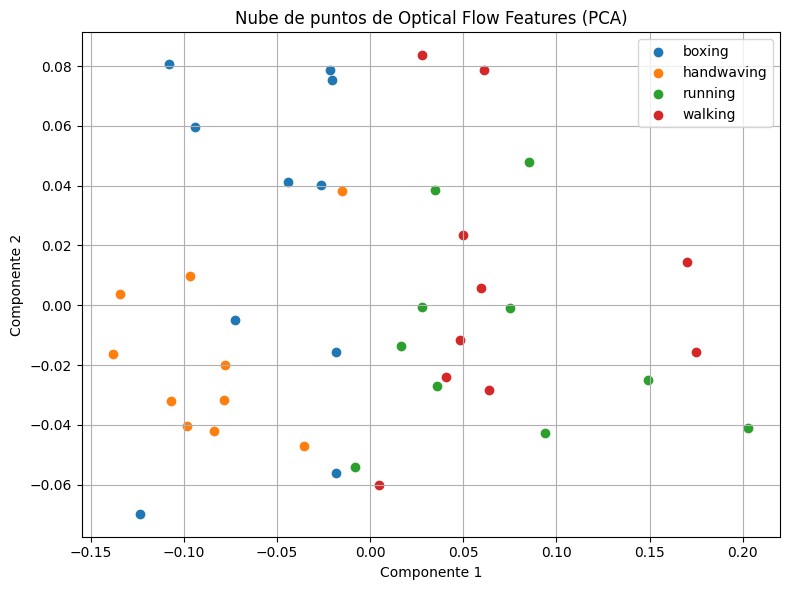

In [ ]:
# Opcional: Proyección de los datos a 2D con PCA para visualización

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Graficar la nube de puntos
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], label=label)

plt.title("Nube de puntos de Optical Flow Features (PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Guardamos el modelo y datos para futuras pruebas (opcional)
#output_npz_path = "/mnt/data/flow_features_all_actions.npz"
#np.savez(output_npz_path, X=X, y=y)

#output_npz_path

In [ ]:
#!pip freeze > requirements.txt